# Chapter 13: Geospatial R Raster

[JP Gannon](https://jpgannon.github.io/)
[](https://orcid.org/0000-0002-4595-3214)
([Virginia Tech](https://www.vt.edu/))  
2025-12-10

# Geospatial R Raster - Hydro Analyses

## Introduction

The following activity is available as a template github repository at
the following link:
https://github.com/VT-Hydroinformatics/13-Geospatial-Raster-Hydro.git

For more:
https://geocompr.robinlovelace.net/spatial-class.html#raster-data

To read in detail about any of the WhiteboxTools used in this activity,
check out the user manual:
https://jblindsay.github.io/wbt_book/intro.html

In this activity we are going to explore how to work with raster data in
R while computing several hydrologically-relevant landscape metrics
using the R package whitebox tools. Whitebox is very powerful and has an
extensive set of tools, but it is not on CRAN. You must install it with
the commented-out line at the top of the next code chunk.

Install/Load necessary packages and data:

In [1]:
library(tidyverse)
library(terra)
library(sf)
library(whitebox)
library(tmap)

#If installing/using whitebox for the first time
install_whitebox()

whitebox::wbt_init()

theme_set(theme_classic())

Warning message:
"package 'tidyverse' was built under R version 4.3.3"
Warning message:
"package 'readr' was built under R version 4.3.3"
Warning message:
"package 'dplyr' was built under R version 4.3.3"
Warning message:
"package 'forcats' was built under R version 4.3.3"
Warning message:
"package 'lubridate' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'terra' was built under R version 4.3.3"
terra 1.8.29


Attaching package: 'terra'


The following object

Performing one-time download of WhiteboxTools binary from
     https://www.whiteboxgeo.com/WBT_Windows/WhiteboxTools_win_amd64.zip 
(This could take a few minutes, please be patient...)
WhiteboxTools binary is located here:  C:/Users/AbnerBogan/AppData/Roaming/R/data/R/whitebox/WBT/whitebox_tools.exe 
You can now start using whitebox
    library(whitebox)
    wbt_version()

## Read in DEM

First, we will set tmap to either map or view depending on how we want
to see our maps. I’ll often set to map unless I specifically need to
view the maps interactively because if they are all set to view it makes
scrolling through the document kind of a pain: every time you hit a map
the scroll zooms in or out on the map rather than scrolling the
document.

For this activity we are going to use a 5-meter DEM of a portion of a
Brush Mountain outside Blacksburg, VA.

*What does DEM stand for? What does it show?  
*What does it mean that the DEM is “5-meter”?

We will use rast() to load the DEM. We let R know that coordinate system
is WGS84 by setting the crs equal to ‘+init=EPSG:4326’ using the crs()
funciton, where 4326 is the EPSG number for WGS84.

Next, an artifact of outputting the DEM for this analysis is that there
are a bunch of errant cells around the border that don’t belong in the
DEM. If we make a map with them, it really throws off the scale. So we
are going to set any elevation values below 1500 ft to NA. Note how this
is done as if the dem was just a normal vector. COOL!

In [2]:
tmap_mode("view")

dem <- rast("McDonaldHollowDEM/brushDEMsm_5m.tif")

crs(dem) <- '+init=EPSG:4326'

writeRaster(dem, "McDonaldHollowDEM/brushDEMsm_5m_crs.tif", overwrite = TRUE) 

dem[dem < 1500] <- NA

ℹ tmap modes "plot" - "view"
ℹ toggle with `tmap::ttm()`
This message is displayed once per session.

## Plot DEM

Now let’s plot the DEM. We will use the same syntax as we did in the
previous lecture about vector data. Give tm_shape the raster, then
visualize it with tm_raster. We will tell tmap that the scale on the
raster is continuous, which color palette to use, whether or not to show
the legend, and then add a scale bar.

In [3]:
tm_shape(dem)+
  tm_raster(style = "cont", palette = "PuOr", legend.show = TRUE)+
  tm_scale_bar()



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "PuOr" is named
"brewer.pu_or"
Warning message:
"tm_scale_intervals `label.style = "continuous"` implementation in view mode
work in progress"

## Generate a hillshade

Since the DEM is just elevation values, it is tough to see much about
the landscape. We can see the stream network and general features, but
not much more. BUT those features are there! We just need other ways to
illuminate them. One common way to visualize these kind of data is a
hillshade. This basically “lights” the landscape with a synthetic sun,
casting shadows and illuminating other features. You can control the
angle of the sun and from what direction it is shining to control the
look of the image. We will position the sun in the south-south east so
it illuminates the south side of Brush Mountain well.

We will use the whitebox tools function wbt_hillshade() to produce a
hillshade.

### How whitebox tools functions work

The whitebox tools functions work can be a little tricky to work with at
first. You might want to pass R objects to them and get R objects back,
but that’s not how they are set up.

Basically for your input, you well the wbt function the name of the file
that has the input data.  
For output, you tell it what to name the output.

The wbt function then outputs the calculated data to your working
directory, or whatever directory you give it in the output argument.

This means if you want to do something with the output of the wbt
function, you have to read it in separately.

In the chunk below we will read in the brush mountain 5m DEM and output
a hillshade with wbt_hillshad().

We will then read the output hillshade in with raster() and make a map
with tmap. We will use the “Greys” palette in revers by adding a
negative sign in front of it. This is just to make the hillshade look
nice.

Notice how much more you can see in the landscape!

In [4]:
wbt_hillshade(dem = "McDonaldHollowDEM/brushDEMsm_5m_crs.tif",
              output = "McDonaldHollowDEM/brush_hillshade.tif",
              azimuth = 115)

hillshade <- rast("McDonaldHollowDEM/brush_hillshade.tif")

tm_shape(hillshade)+
  tm_raster(style = "cont", palette = "-Greys", legend.show = FALSE)+
  tm_scale_bar()



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")
Warning message:
"tm_scale_intervals `label.style = "continuous"` implementation in view mode
work in progress"

## Prepare DEM for Hydrology Analyses

Alright, we are cooking now.

But we have to cool our jets for a second. If we are going to do
hydrologic analyses, we have to prep our DEM a bit.

Our hydrologic tools often work on the premise of following water down
the hillslope based on the elevation of the cells in the DEM. If, along
a flowpath, there is no cell lower than a location, the algorithm we are
using will stop there. This is called a sink, pit, or depression. See
the figure below.

<img src="./images/sink.png" alt="Sink" width="1000">

Figure 1: Sink

We can deal with these features two ways. The first is to “fill” them.
Which means the dead end cells will have their elevations raised until
the pit is filled and water can flow downhill. See below.

<img src="./images/filled.png" alt="Filled" width="1000">

Figure 2: Filled

The second way we can deal with these features is to “breach” them. This
means the side of the feature that is blocking flow will be lowered to
allow water to flow downhill. See below.

<img src="./images/breached.png" alt="Breached" width="1000">

Figure 3: Breached

We are going to do both to prep our DEM. We will first breach
depressions using wbt_breach_depressions_least_cost(), which will lower
the elevation of the cells damming depressions.

To use this function we will also give it a maximum distance to search
for a place to breach the depression (dist) and tell with whether to
fill any depressions leftover after it does its thing (fill).

Then, because this algorithm can leave some remaining depressions, we
wil use wbt_fill_depressions_wang_and_liu() to clean up any remaining
issues.

Be careful to give wbt_fill_depressions_wang_and_liu() the result of the
breach depressions function, not the original DEM!

In [5]:
wbt_breach_depressions_least_cost(
  dem = "McDonaldHollowDEM/brushDEMsm_5m_crs.tif",
  output = "McDonaldHollowDEM/bmstationdem_breached.tif",
  dist = 5,
  fill = TRUE)

wbt_fill_depressions_wang_and_liu(
  dem = "McDonaldHollowDEM/bmstationdem_breached.tif",
  output = "McDonaldHollowDEM/bmstationdem_filled_breached.tif"
)

## Visualize filled sinks and breached depressions

Now let’s look at what this did. This is a great example of how easily
you can use multiple rasters together.

If we want to see how the fill and breach operations changed the DEM, we
can just subtract the filled and breached DEM from the original. Then,
in areas where nothing changed, the values will be zero, areas that were
filled will be positive, and areas that were decreased in elevation to
“breach” a depression will be negative.

To more easily see where stuff happened, we will set all the cells that
equal zero to NA. Then we will plot them on the hillshade.

Where where changes made?

What do you think these pit/depression features represent in real life?

In [6]:
filled_breached <- rast("McDonaldHollowDEM/bmstationdem_filled_breached.tif")

## What did this do?
difference <- dem - filled_breached

difference[difference == 0] <- NA

tm_shape(hillshade)+
  tm_raster(style = "cont",palette = "-Greys", legend.show = FALSE)+
  tm_scale_bar()+
tm_shape(difference)+
  tm_raster(style = "cont",legend.show = TRUE)+
  tm_scale_bar()



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")
Variable(s) "col" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full range of visual values.

Warning message:
"tm_scale_intervals `label.style = "continuous"` implementation in view mode
work in progress"
Warning message:
"tm_scale_intervals `label.style =

## D8 Flow Accumulation

The first hydrological analysis we will perform is the D8 flow
accumulation algorithm. In whitebox this is wbt_d8_flow_accumulation().
We give the function the DEM, and for each cell, it determines the
direction water fill flow from that cell. To do this it looks at the
elevation of the surrounding cells relative to the current cell. In the
D8 algorithm, the flow direction can be one of 8 directions, show in the
figure below. All flow from the current cell is moved to the cell to
which the flow direction points.

Using another function, we can just output the flow direction for each
cell. This will be important when we delineate a watershed, but for
visualization and many analysis purposes, we just want to look at the
flow accumulation.

This tool outputs a raster that tells us how many cells drain to each
cell. In other words, for a given cell in the raster, its value
corresponds to the number of cells that drain to it. As a result, this
highlights streams quite well.

<img src="./images/D8-flow-direction.png" alt="D8 Flow Direction" width="1000">

Figure 4: D8 Flow Direction

The wbt_d8_flow_accumulation() function takes an input of a DEM or a
flow direction (pointer) file. We will pass it out filled, breached DEM.
The default output is the number of cells draining to each cell, but you
can also choose specific contributing area or contributing area.

We will visualize our output buy plotting the log of the D8 flow
accumulation grid over the hillshae with an opacity of 0.5 using the
alpha parameter in tm_raster. Mapping with the hillshade helps us see
the flow accumulation in the context of the landscape. Ploting the log
values helps us see differences in flow accumulation, because the high
values are so much higher than the low values in a flow accumulation
grid.

Where are the highest values? Where are the lowest values?

In [7]:
wbt_d8_flow_accumulation(input = "McDonaldHollowDEM/bmstationdem_filled_breached.tif",
                         output = "McDonaldHollowDEM/D8FA.tif")

d8 <- rast("McDonaldHollowDEM/D8FA.tif")

tm_shape(hillshade)+
  tm_raster(style = "cont",palette = "-Greys", legend.show = FALSE)+
tm_shape(log(d8))+
  tm_raster(style = "cont", palette = "PuOr", legend.show = TRUE, alpha = .5)+
  tm_scale_bar()



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
[v3->v4] `tm_raster()`: use `col_alpha` instead of `alpha`.
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "PuOr" is named
"brewer.pu_or"
Warning message:
"tm_scale_intervals `label.style = "continuous"` implementation in view mode
work in progress"
Warning message:
"tm_scale_intervals `l

## D infinity flow accumulation

Another method of calculating flow accumulation is the D infinity
algorithm. This operates similarly to the D8 algorithm but with some
important differences.

With D infinity, the flow direction for each cell can be any angle.
Endless possibilities!

If the angle does not point squarely at one of the neighboring cells,
the flow from the focus cell can be SPLIT between neighboring cells. We
will see the resulting difference this makes when we look at the output.

<img src="./images/dinf-flow direction.png" alt="D inf Flow Direction" width="1000">

Figure 5: D inf Flow Direction

The function for d infinity is wbt_d_inf_flow_accumulation() and like
the D8 function it will take a flow direction (pointer) file or a DEM.
We will give it out filled and breached DEM.

As with the D8 data, we will plot the logged accumulation values over a
hillshade with 50% opacity.

How does this look different from the D8 results?

Which do you think represents reality better? Why?

In [8]:
wbt_d_inf_flow_accumulation("McDonaldHollowDEM/bmstationdem_filled_breached.tif",
                         "McDonaldHollowDEM/DinfFA.tif")

dinf <- rast("McDonaldHollowDEM/DinfFA.tif")

tm_shape(hillshade)+
  tm_raster(style = "cont",palette = "-Greys", legend.show = FALSE)+
tm_shape(log(dinf))+
  tm_raster(style = "cont", palette = "PuOr", legend.show = TRUE, alpha = 0.5)+
  tm_scale_bar()



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
[v3->v4] `tm_raster()`: use `col_alpha` instead of `alpha`.
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "PuOr" is named
"brewer.pu_or"
Variable(s) "col" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full range of visual values.

Warning m

## Topographic Wetness Index

The topographic wetness index (TWI) combines flow accumulation with the
slope of each cell to calculate a index that basically corresponds to
how likely an area is to be wet. If we think about a landscape, an area
with a lot of contributing area and a flat slope is more likely than an
area with a lot of contributing area and a steep slope to be wet. That’s
what TWI measures.

The formula for TWI is

$TWI = Ln(As / tan(Slope))$

Where As is the specific contributing area and Slope is the slope at the
cell. Specific contributing area is contributing area per unit contour
length.

This is the first function we will use that doesn’t just take a DEM as
input. The wbt_wetness_index() function takes a raster of specific
contributing area and another of slope. We will need to create each of
these first and then pass them to the function (since we didn’t
calculate specific contributing area when we used the flow accumulation
algorithms above)

We will then plot TWI with the same approach we used for the flow
accumulation data.

We get some funkiness around the edges of the DEM, so we will also
filter the twi output so the visualization looks better.

In [9]:
wbt_d_inf_flow_accumulation(input = "McDonaldHollowDEM/bmstationdem_filled_breached.tif",
                            output = "McDonaldHollowDEM/DinfFAsca.tif",
                            out_type = "Specific Contributing Area")

wbt_slope(dem = "McDonaldHollowDEM/bmstationdem_filled_breached.tif",
          output = "McDonaldHollowDEM/demslope.tif",
          units = "degrees")

wbt_wetness_index(sca = "McDonaldHollowDEM/DinfFAsca.tif",
                  slope = "McDonaldHollowDEM/demslope.tif",
                  output = "McDonaldHollowDEM/TWI.tif")

twi <- rast("McDonaldHollowDEM/TWI.tif")

twi[twi > 0] <- NA

tm_shape(hillshade)+
  tm_raster(style = "cont",palette = "-Greys", legend.show = FALSE)+
tm_shape(twi)+
  tm_raster(style = "cont", palette = "PuOr", legend.show = TRUE, alpha = 0.5)+
  tm_scale_bar()



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
[v3->v4] `tm_raster()`: use `col_alpha` instead of `alpha`.
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "PuOr" is named
"brewer.pu_or"
Warning message:
"tm_scale_intervals `label.style = "continuous"` implementation in view mode
work in progress"
Warning message:
"tm_scale_intervals `l

## Downslope TWI

Another index of interest is the downslope index. The downslope index is
the measure of slope between a cell and then another cell a specified
distance downslope. We can replace the regular slope number in the TWI
calculation with downslope index to calculate TWId or Downslope TWI.

$TWI = Ln(As / tan(DownslopeIndex))$

As is specific contributing area, and the tan of the downslope index can
be output from the whitebox downslope index tool. We have to do this
calculation with the rasters becasue there isn’t a specific whitebox
tool that calculateds TWId.

Essentially, this index captures the fact that you should expect a 50
meter long bench on a hillslope to be wetter than a 1 meter long bench,
because the 1 meter one would drain a lot faster.

Similar to TWI we get some edge issues so we will filter the result to
make the visualization look better.

In [10]:
wbt_downslope_index(dem = "McDonaldHollowDEM/bmstationdem_filled_breached.tif",
                    output = "McDonaldHollowDEM/downslope_index.tif",
                    out_type = "tangent")

downslope_index <- rast("McDonaldHollowDEM/downslope_index.tif")

dinfFA <- rast("McDonaldHollowDEM/DinfFAsca.tif")

twid <- log(dinfFA / downslope_index)

twid[twid > 40] <- NA

tm_shape(hillshade)+
  tm_raster(style = "cont",palette = "-Greys", legend.show = FALSE)+
tm_shape(twid)+
  tm_raster(style = "cont", palette = "PuOr", legend.show = TRUE, alpha = 0.5)+
  tm_scale_bar()



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
[v3->v4] `tm_raster()`: use `col_alpha` instead of `alpha`.
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "PuOr" is named
"brewer.pu_or"
Warning message:
"tm_scale_intervals `label.style = "continuous"` implementation in view mode
work in progress"
Warning message:
"tm_scale_intervals `l

## Map Stream Network

One neat and often very useful thing we can do with the flow
accumulation grids we calculated, is map the stream network in a
watershed. If we look at either flow accumulation grid we can see the
highest values are in the streams. Therefore if we determine the flow
accumulation value at the highest place on the streamnetwork with
consistent flow, we can set all cells with a flow accumulation lower
than that to NO and we will only have cells that are in the stream.

Often, we actually want out stream network to be represented as lines,
so we then have to convert that raster to a vector format.

Whitebox Tools has two handy functions to let us do this:
wbt_extract_streams() makes a raster of the stream network by using a
threshold flow accumulation you give it. It takes a D8 flow accumulation
grid as input.

Then wbt_raster_streams_to_vector() will take the outut from
wbt_extract_streams() and a D8 pointer file and output a shapefile of
your stream network.

Below we extract the streams, generate a D8 pointer file, and then
convert the raster streams to vector. We will then plot the streams on
the hillshade.

In [11]:
wbt_extract_streams(flow_accum = "McDonaldHollowDEM/D8FA.tif",
                    output = "McDonaldHollowDEM/raster_streams.tif",
                    threshold = 6000)

wbt_d8_pointer(dem = "McDonaldHollowDEM/bmstationdem_filled_breached.tif",
               output = "McDonaldHollowDEM/D8pointer.tif")

wbt_raster_streams_to_vector(streams = "McDonaldHollowDEM/raster_streams.tif",
                             d8_pntr = "McDonaldHollowDEM/D8pointer.tif",
                             output = "McDonaldHollowDEM/streams.shp")

streams <- read_sf("McDonaldHollowDEM/streams.shp")

tm_shape(hillshade)+
  tm_raster(style = "cont",palette = "-Greys", legend.show = FALSE)+
tm_shape(streams)+
  tm_lines(col = "blue")+
  tm_scale_bar()



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")
Warning message:
"tm_scale_intervals `label.style = "continuous"` implementation in view mode
work in progress"

## Extract raster values to point locations

Now let’s say you have some sample or monitoring sites in this study
area. You may want to know what the values of the rasters we just made
are for your sites. Below we will read in the coordinates of a few sites
and extract data from a single raster and then multiple at once.

### Import and plot points

First, we will read in a csv of point locations. Then we have to convert
it to a spatial datatype. We will use st_as_sf() to do this. We need to
give it our points, and then cell it what projection and format our data
is in. We are using geographic coordinates (lon, lat) and the WGS84
datum (most gps’ use this and it is EPSG 4326).

Then we will plot the points just to make sure they show up where we
expect.

Rows: 3 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): lon, lat

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
ℹ tmap modes "plot" - "view"


── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "PuOr" is named
"brewer.pu_or"

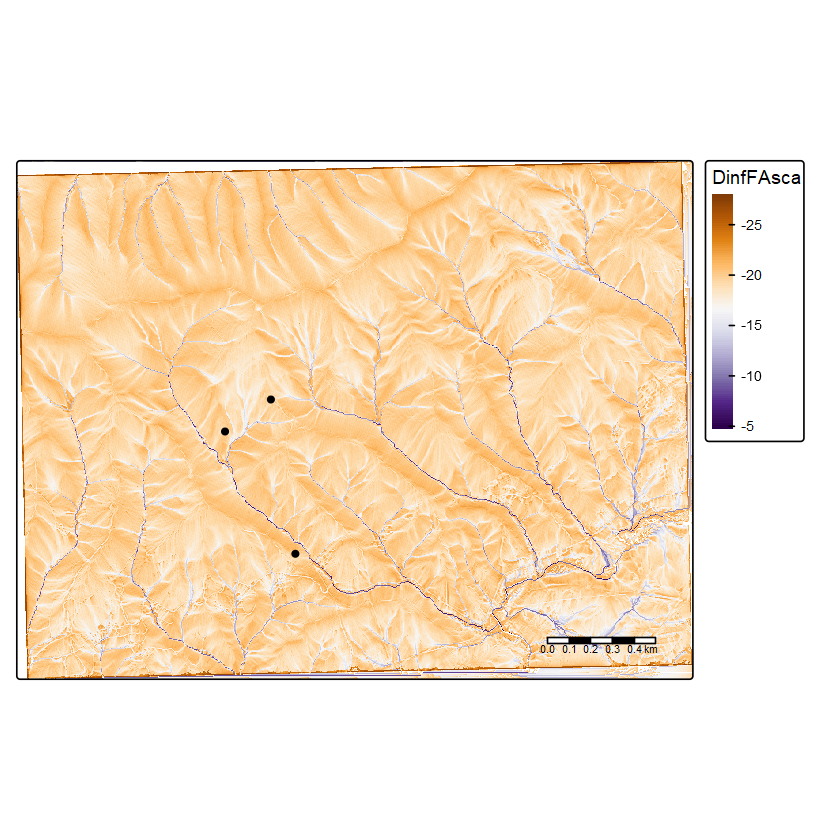

In [12]:
points <- read_csv("McDonaldHollowDEM/points.csv")

pointsSP <- st_as_sf(points, coords = c("lon", "lat"), crs = 4326)

tmap_mode("plot")

tm_shape(twid)+
  tm_raster(style = "cont", palette = "PuOr", legend.show = TRUE)+
  tm_scale_bar()+
tm_shape(pointsSP)+
  tm_dots(col = "red")

### Extract values from a single raster

We can extract values from any raster using the extract() function in
the raster package. We give this funciton the raster we want to pull
data from (x) and the points where we want data (y). Then we specify how
we want it to grab data from the raster. “Simple” just grabs the value
at the locaitons specified. If we specify “bilinear” it will return an
interpolated value based on the four nearest raster cells.

This function just spits out a vector of values disconnected from our
points, so next we will add the column to our existing points object.
NOT the geospatial one, just the datafram/tibble.

In [13]:
twidvals <-  extract(x = twid, #raster 
                 y = pointsSP, #points
                 method = "simple")

points$twid <- twidvals$DinfFAsca

print(points)

# A tibble: 3 × 3
    lon   lat  twid
  <dbl> <dbl> <dbl>
1 -80.5  37.2 -19.9
2 -80.5  37.2 -19.6
3 -80.5  37.2 -18.3

### Extract values from multiple rasters at once

Maybe you want a bunch of topographic information for all your sample
sites. You could repeat the process above for each one, or we can stack
the rasters of interest and then pull out values for each using the same
method as below. WHOA!

So: we give c() each raster we want data from, using the rasters we read
in earlier in the activity

Then: use the same exact syntax as when we extracted values from a
single raster, but give the extract funciton the stacked raster.

We can then use cbind() to slap the extracted data onto our existing
dataframe (gain, NOT the spatial one, just the original regular one)

In [14]:
slope <- rast("McDonaldHollowDEM/demslope.tif")

raster_stack <- c(twi, twid, slope, dem)

raster_values <-extract(x = raster_stack, #raster 
                 y = pointsSP, #points
                 method = "simple")

points <- cbind(points, raster_values)

print(points)

        lon      lat      twid ID       TWI DinfFAsca demslope brushDEMsm_5m
1 -80.48355 37.24087 -19.90985  1 -8.450521 -19.90985 43.42010      2130.564
2 -80.48705 37.24570 -19.64899  2 -8.174915 -19.64899 57.76965      2301.624
3 -80.48477 37.24697 -18.29477  3 -6.870579 -18.29477 30.68143      2430.992

## View raster data as a PDF or histogram

Often if can be useful to look at a summary of different topographic
characteristics in an area or watershed outside of a map. One way we can
do this is to look at a histogram or pdf of the values in our map by
converting the raster values to a dataframe and plotting with ggplot.

We will use as.data.frame to convert our slope raster to a data frame
and then plot the result in ggplot with stat_density.

It would be very difficult to accurately describe the differences in
slope between two areas by looking at a map of the values, but this way
we can do it quite effectively.

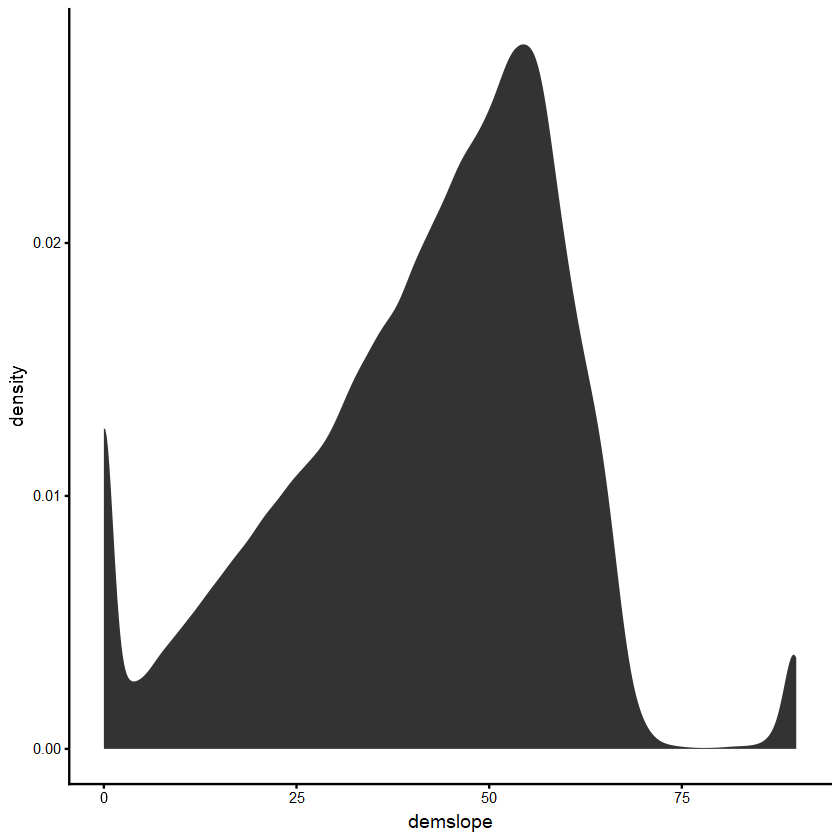

In [15]:
slopedf <- as.data.frame(slope)

ggplot(slopedf, aes(demslope)) +
  stat_density()

## Subsetting a raster for visualization

Similar to how we set junky values to NA earlier in this activity, we
can also use this as a visualization tool. We will create a new raster
with areas with a slope of less than 60 percent set to NA. When we plot
this, it will just show slope where slope is greater than 60.

At it’s heart this is a reclassification. You could use the same
strategy to classify slopes into bins. For example, make slopes from 0 -
60 percent equal to 1, for low slope, and then \> 60 equal to 2 for high
slope… or any number of bins. This can be really useful for finding
locations that satisfy a several criteria. Think: where might we find
the right habitat for a certain tree species, or bird, or sasquatches?



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "PuOr" is named
"brewer.pu_or"

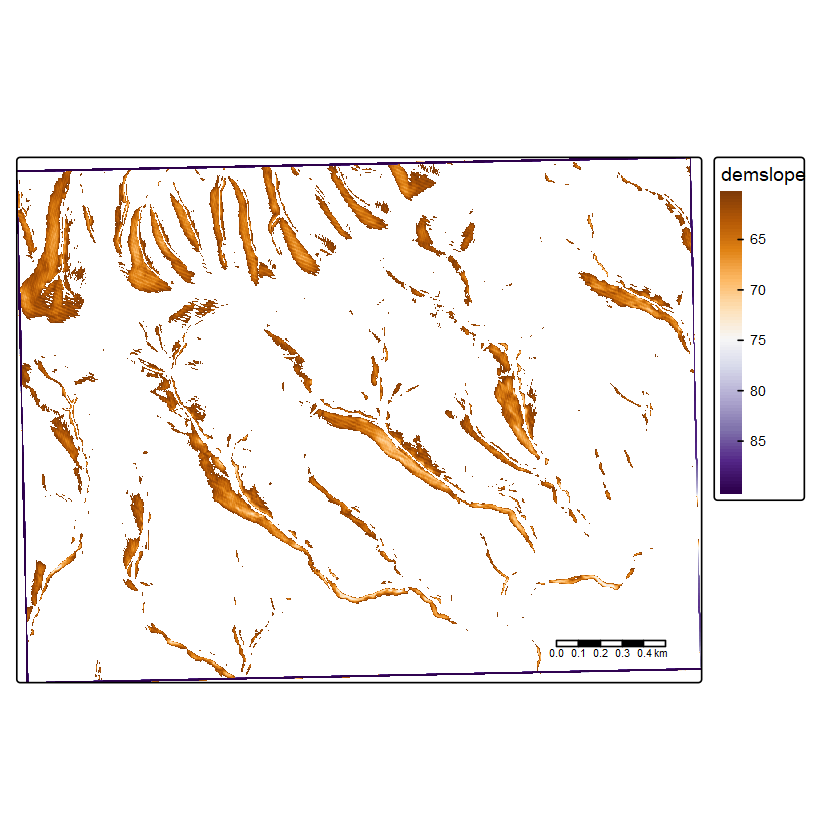

In [16]:
slope2 <- slope
slope2[slope2 < 60] <- NA

tm_shape(slope2)+
  tm_raster(style = "cont", palette = "PuOr", legend.show = TRUE)+
  tm_scale_bar()

## Raster Math

Super quick: you can also do math with your rasters!

If you’ve made model that predicts the likelihood of the location or
something, you can just plug your rasters in like a normal equation and
it’ll do the math and you can map it! SO. COOL.

Here’s a super simple example to just illustate that you can do this: we
will just divide slope by the elevation (dem)



── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "PuOr" is named
"brewer.pu_or"

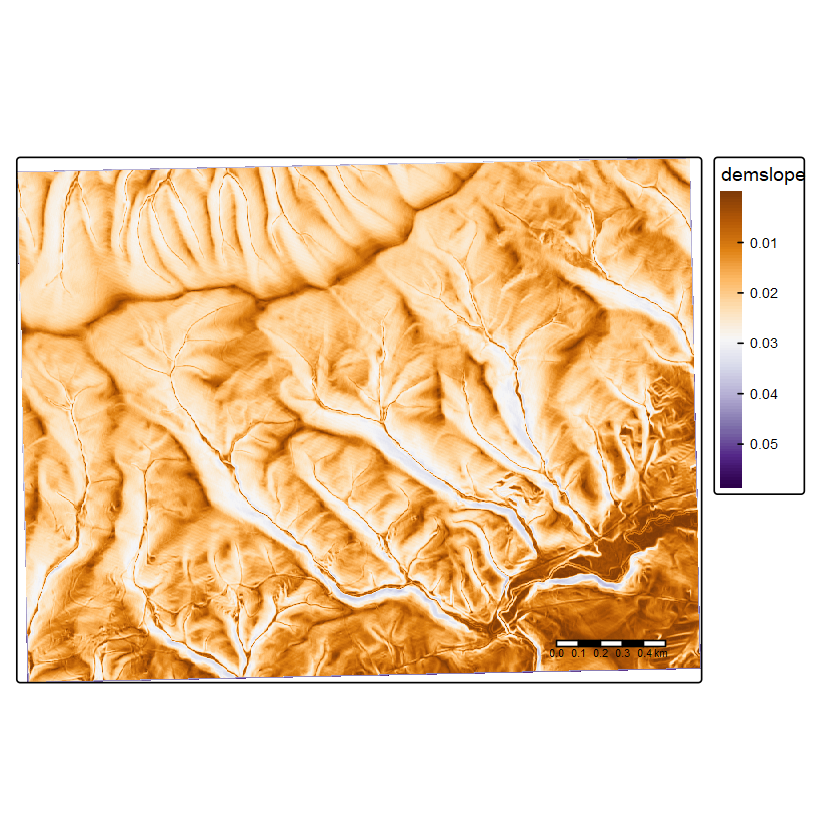

In [17]:
demXslope <- slope / dem

tm_shape(demXslope)+
  tm_raster(style = "cont", palette = "PuOr", legend.show = TRUE)+
  tm_scale_bar()

## Extra: plot topo characteristics against one another

Here we convert the raster stack to a dataframe and then plot a 2
dimensional density plot.

Warning message:
"Removed 19206 rows containing non-finite outside the scale range
(`stat_density2d_filled()`)."

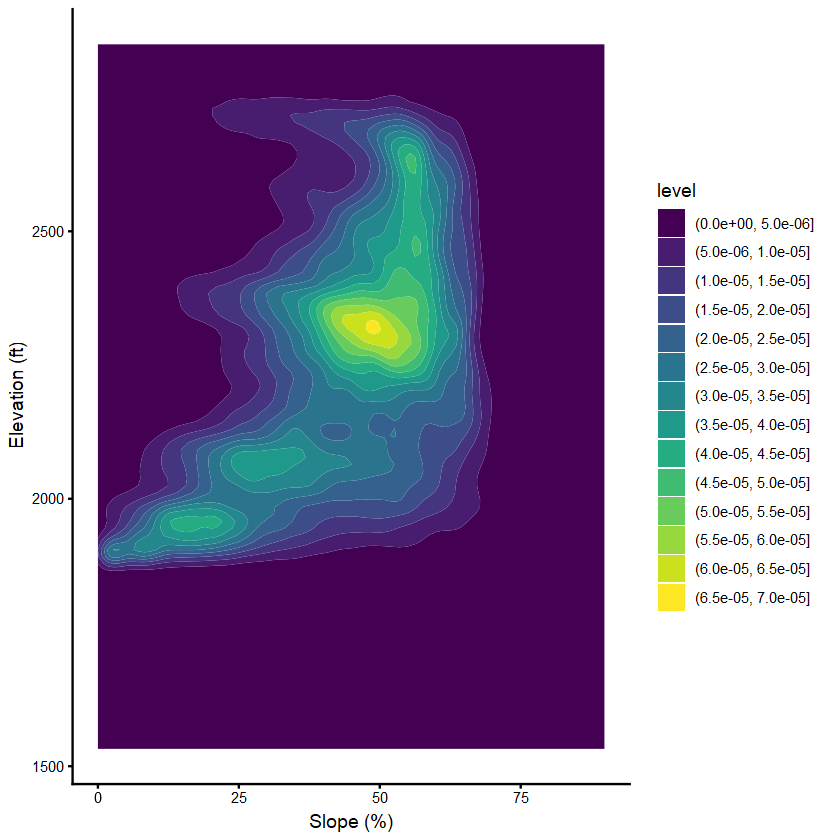

In [18]:
rasters_df <- as.data.frame(raster_stack)

ggplot(rasters_df, aes(x = demslope, y = brushDEMsm_5m))+
  geom_density_2d_filled()+
  ylab("Elevation (ft)")+
  xlab("Slope (%)")
